# 2.03d Analysing Glycaemic Variability
This notebook looks at blood glucose in terms of glycaemic variability.

Glycaemic control has traditionally been the measured using HbA1c, a term used for glycated haemoglobin, which is made when the glucose sticks to red blood cells. As blood sugar can't be used properly, more of it binds to blood cells and increases the volume in haemoglobin. Readings are taken quarterly as red blood cells are active for 2-3 months. Thus, a high HbA1c result indicates high blood sugar levels, and with it the various risks and complications that a patient faces. HbA1c will not give an idea of fluctuations in blood sugar levels whereas CGM monitors offer the ability to monitor BG at a much greater resolution. Glycaemic variability can measured more with a range of metrics, including but not limited to:
- Time in range (TIR)
- Coefficient of Variation (CV)
- Standard Deviation (SD)
- Mean Amplitude of Glycaemic Excursions (MAGE)
- Continuous overall net glycaemic action (CONGA)
- High/Low Blood Glucose Index (H/LBGI)

This analysis will focus on the SD, CV at each timepoint, and the amplitude of glycaemic excursion from the MAGE metric, which identifies and calculates the excursion that qualify under its logic.

SD is measured by:

$SD = \sqrt{\frac{\sum{(x-\bar{x})^2}}{n-1}}$

where $\bar{x}$ is the mean of the glucose data.

CV is also a statistical metric which focuses on the diversity of glucose data, and is one of the most used metrics for glycaemic variation \cite{Rodard2018} <NEEDS REFERENCE AS OFFLINE>. CV is calculated as:

$CV = \frac{SD}{\bar{x}}$

CV is a unitless measure, and is often expressed as a percentage.

MAGE is a measure of the amplitude of glycaemic excursions originally proposed by Service et al \cite{Service1970}, and is calculated as the mean of the absolute differences between consecutive peaks and troughs in glucose data. It is a measure of the magnitude of fluctuations in glucose levels, and is often used to assess glycaemic variability in patients with diabetes. MAGE is an algorithm that Surabhi et al. \cite{Surabhi2013} formalise as:

$MAGE = \sum{\frac{\lambda}{n}}$ if $\lambda > v$

where:
- $\lambda = $ each blood glucose increase or decrease (nadir-peak or peak-nadir).
- $n$ is the number of glucose measurements.
- $v$ is one standarard deviation from the mean of the glucose data for the period.

The features extracted at each interval for the night are qualifying excursion amplitudes and a binary flag to denote an excursion, based on an implementation of MAGE provided in the `cgmquantify` package \cite{Bent2021}. This omits the final averaging step that MAGE would normally undertake to give a metric for the whole observed period, given that we want to understand patterns across the period rather than using an overall mean for the night. This better facilitates the split needs: a) to represent variability over time and when implementing any model for prediction and b) aggregation as a component (to include the averaging step for the observed period) for an objective function.


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
from sklearn.preprocessing import StandardScaler
from datetime import time, datetime, timedelta

from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.features import FeatureSet
from src.config import PROCESSED_DATA_DIR
from src.nights import Nights, consolidate_df_from_nights
from src.time_series_analysis import plot_night_time_series
from src.dba import dba_by_cluster
from src.helper import normalise_overnight_time, get_time_period, generate_alphabetical_aliases

2025-08-13 19:16:56.636 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [3]:
with open(PROCESSED_DATA_DIR / 'cust_analyser.pkl', 'rb') as file:
    analyser = pickle.load(file)

df_all = analyser.return_dataset_with_clusters()
df_all = df_all.rename(columns={'cluster_label': 'cluster'})
# df_all = pd.read_parquet(PROCESSED_DATA_DIR / 'night_clusters.parquet')
df_all['time'] = df_all.index.get_level_values('datetime').time

night_start = time(17, 0)
morning_end = time(11, 0)
sample_rate = 30
# nights_objects = []
variables = ['cob mean', 'iob mean', 'bg mean']
info_cols = ['night_start_date', 'time', 'cluster']
excursion_cols = ['excursion_amplitude', 'excursion_count']

When BG, COB and IOB data are plotted, the data is:
1. First scaled (such that the definition in the shape of the data is preserved), then
2. Averaged using Dynamic Barycentric Averaging (DBA) and then,
3. Plotted.

The purpose of step 1 and 2 in the workflow is as follows. Scaling is done using a standard scaler throughout the analysis (using Sci-Kit Learn's `StandardScaler`), which avoids the need to handle outliers in the data given that it is more robust to these, and particularly for the purpose of plotting will ensure the shape of the profiles aren't dominated by them. The DBA is used to average the data across the night, which is useful for visualisation and comparison of the profiles, as it allows for a more representative view of the data by reducing noise and variability in the data. This is particularly useful when comparing profiles across different nights or individuals. It allows for a more consistent representation. However, in terms of where this is done in the workflow, it is following scaling, and it is done consistently with the same variables (`['bg mean', 'cob mean', 'iob mean']`) across the analysis. This means that the DBA is not used to calculate the features, but rather to visualise the data and compare profiles across nights and individuals. Thus, when plotting there will be discrepancies at times in alignment of features to the original variables due to warping.

In [4]:
df_scaled = df_all[info_cols + variables].copy()
df_scaled[variables] = StandardScaler().fit_transform(df_scaled[variables])
df_long_bg = dba_by_cluster(df_scaled, variables, night_start.hour, morning_end.hour, 'cluster')  # Find DBA averages over 17:00-11:00 period to ensure calculation is the same
df_long_bg = df_long_bg.set_index(['cluster', 'time'])

night_start = time(22, 0)
morning_end = time(6, 30)  # Used to ensure there are excursion readings up until 06:00 to populate visualisations

# for zip_id, df_ind in df_all.groupby('id'):
#     df_ind_reset = df_ind.reset_index(level='id', drop=True)
#     nights_objects.append(
#         Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
#                morning_end=morning_end, sample_rate=sample_rate))


df_overnight = get_time_period(df_all, night_start, morning_end)

## Standard Deviation and Coefficient of Variation
The standard deviation and coefficient of variation are simple to calculate but common measures of variability, and from the preprocessed data we have the standard deviation calculated at each interval as part of the preprocessing . The coefficient of variation will be calculated at each intereval using this divided by the mean value, as follows.


In [5]:

# 'bg std' hasn't been loaded using previous method, so loading here
# night_start = time(22, 0)
# morning_end = time(6, 0)
# sampling = ThirtyMinute()
# min_nights = 30
# missed_intervals = 1
# max_break_run = 1
# cob_nan_min = 0.2
# iob_nan_min = 0.05
# bg_nan_min = 0.2
# sample_long = SampleFilter(
#     night_start=night_start,
#     morning_end=morning_end,
#     sampling=sampling,
#     missed_intervals=missed_intervals,
#     max_break_run= max_break_run,
#     min_nights=min_nights,
#     cob_nan_min=cob_nan_min,
#     iob_nan_min=iob_nan_min,
#     bg_nan_min=bg_nan_min
# )
#
#
# df_for_bg_std= sample_long.get_consolidated_df()

df_bg_std = df_overnight.reset_index().copy()
# df_bg_std = df_overnight.join(df_for_bg_std['bg std'], how='left')
df_bg_std['bg cv'] = df_bg_std['bg std'] / df_bg_std['bg mean']
alias_ids = generate_alphabetical_aliases(df_bg_std['id'].unique())
df_bg_std['id'] = df_bg_std['id'].map(alias_ids)

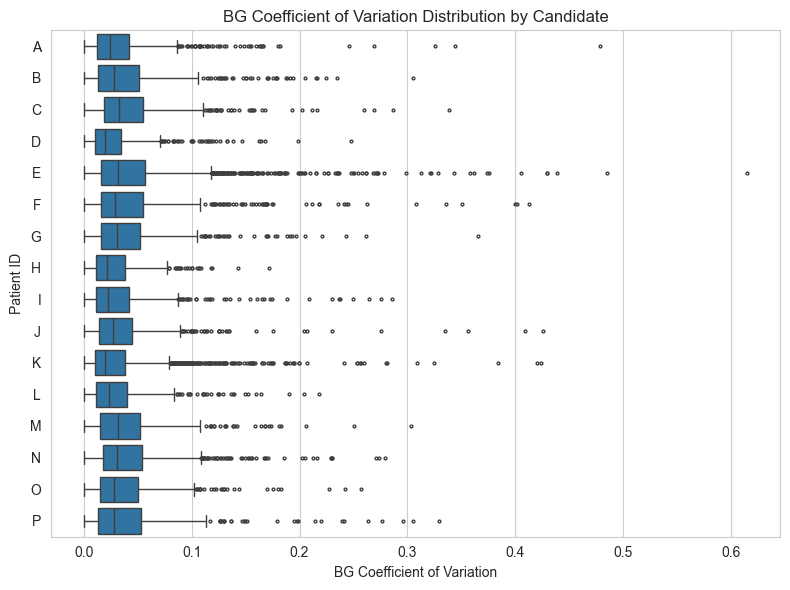

In [6]:
from src.config import FIGURES_DIR

df_bg_cv_id_long = df_bg_std.reset_index()
df_bg_cv_id_long = df_bg_cv_id_long[['id', 'bg cv']].dropna()

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_bg_cv_id_long, y='id', x='bg cv', orient='h', fliersize=2)

plt.title('BG Coefficient of Variation Distribution by Candidate')
plt.xlabel('BG Coefficient of Variation')
plt.ylabel('Patient ID')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cv_distribution_by_patient.png', bbox_inches='tight')
plt.show()

The values for the coefficient have a low mean. This highlights the need - when used in for modelling - to scale the values, most appropriately through StandardScaler given the obvious outliers that would otherwise not result in the adjustment to the lower values as required, in order to normalise them and ensure that their weight is duly considered against other components of an objective function, should this be the direction.

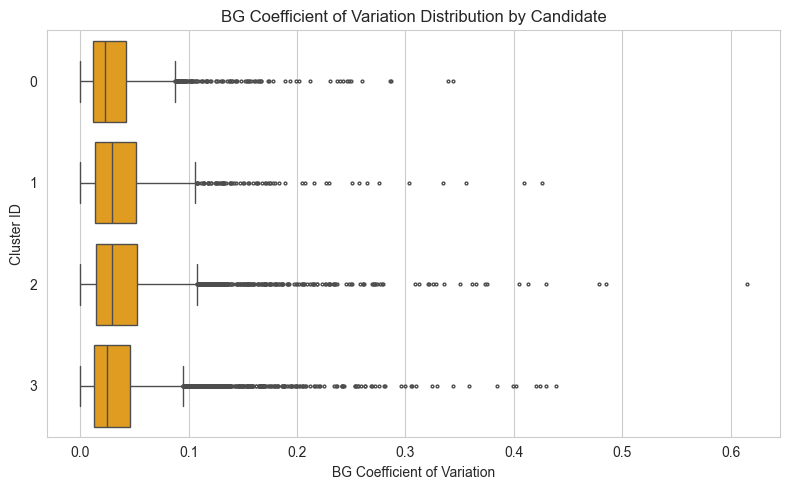

In [7]:
df_bg_cv_cluster_long = df_bg_std.reset_index()
df_bg_cv_cluster_long = df_bg_cv_cluster_long[['cluster', 'bg cv']].dropna()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_bg_cv_cluster_long, y='cluster', x='bg cv', orient='h', fliersize=2, color='orange')

plt.title('BG Coefficient of Variation Distribution by Candidate')
plt.xlabel('BG Coefficient of Variation')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

BG Coefficient of Variation Distribution by Cluster


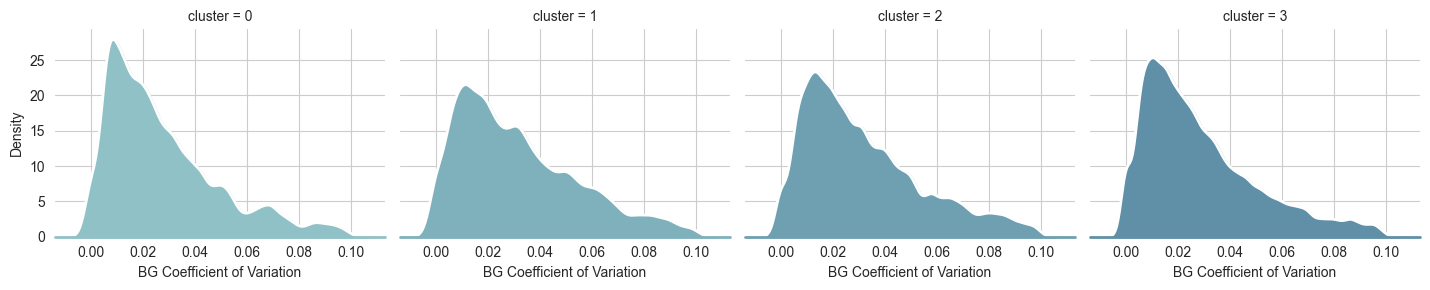

In [8]:
print('BG Coefficient of Variation Distribution by Cluster')

Q1 = df_bg_cv_cluster_long['bg cv'].quantile(0.25)
Q3 = df_bg_cv_cluster_long['bg cv'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_bg_cv_cluster_long[
    (df_bg_cv_cluster_long['bg cv'] >= lower_bound) &
    (df_bg_cv_cluster_long['bg cv'] <= upper_bound)
]

# Create FacetGrid in one row
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_filtered, col="cluster", hue="cluster", aspect=1.2, height=3, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "bg cv",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "bg cv", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.despine(bottom=True, left=True)
g.set(xlabel="BG Coefficient of Variation")

plt.show()

This shows better resolution having removed the outliers from the plots. Each cluster has quite similar distributions with some slight nuance in cluster 2, which show a slightly greater probability density at around 0.009 than the others. Statistically, the mean, median and standard deviation of the coefficient of variation for each cluster is as follows:

In [9]:
df_bg_cv_cluster_long.groupby('cluster')['bg cv'].agg(['mean', 'median', 'std']).round(4)

,mean,median,std
cluster,,,
0,0.0328,0.0230,0.0350
1,0.0387,0.0289,0.0397
2,0.0423,0.0291,0.0462
3,0.0358,0.0246,0.0388


This shows cluster 3 as having a greater mean and standard deviation which isn't obvious in the plots but will be a result of the outliers that were removed. The median is similar across all clusters, which is sign that the data is not skewed by outliers.

## Amplitude of Glycaemic Excursions (derived from MAGE)
Identification and calculation of the amplitude of glycaemic excursions here is based on the method used in the MAGE algorithm. The steps to identify and calculate the amplitude are as follows, assuming the data is already pre-processed into regular intervals:
1. Calculation of the standard deviation of all glucose values in the observation period: In this case, the observation period is the overnight period. This is important as it provides a baseline for the amplitude calculation, and unlike arbitrary thresholds, it is based on the data itself, which means it is personalised to the individual. Therefore, it can be considered a true measure of variablility personalised to the individual, accepting that each individual will have their own ranges of glucose values.
2. Identification of peaks and nadirs: The peaks and nadirs are identified by looking for local maxima and minima in the glucose data. This is done by comparing each value to its neighbours, and identifying points that are higher or lower than both of them. The implementation used identifies 'turning points' and uses iteration to find the next turning point, at which the amplitude between the two can be calculated.
3. Identification of significant excursions: An excursion qualifies as significant if the absolute difference between one turning point and the next is greater than one standard deviation. The amplitude is recorded at that timepoint.
4. Selection of non-overlapping excursions: It is important not to consider overlapping excursions, and so a maximum is used for two consecutive excursions (as with the implementation also by Fernandes et al (https://cran.r-project.org/web/packages/iglu/vignettes/MAGE.html).

The observable period is the 'nocturnal' period of between 22:00 and 06:00, where our concern is in respect disturbance. To provide a backdrop, we'll include the period of 17:00 to 11:00, which is the period of the night clusters, but visualise excursions only in the nocturnal period.

In [10]:
features = FeatureSet(df_overnight, sample_rate=sample_rate)
features.add_sd_excursion_features(mode='turning_point_max_amplitude')
df_with_AGE = features.get_full_df()

In [11]:
excursion_summary = df_with_AGE.groupby(['cluster', 'time'])['excursion_amplitude'].agg(
    excursion_count_mean=lambda x: (x != 0).sum() / x.size,
    excursion_sum='sum',
    excursion_mean='mean')
excursion_summary = excursion_summary.reset_index()
excursion_summary['time'] = excursion_summary['time'].apply(lambda x: normalise_overnight_time(x, morning_end.hour))

excursion_summary = excursion_summary.set_index(['cluster', 'time'])
df_long_bg = df_long_bg.join(excursion_summary, how='left')

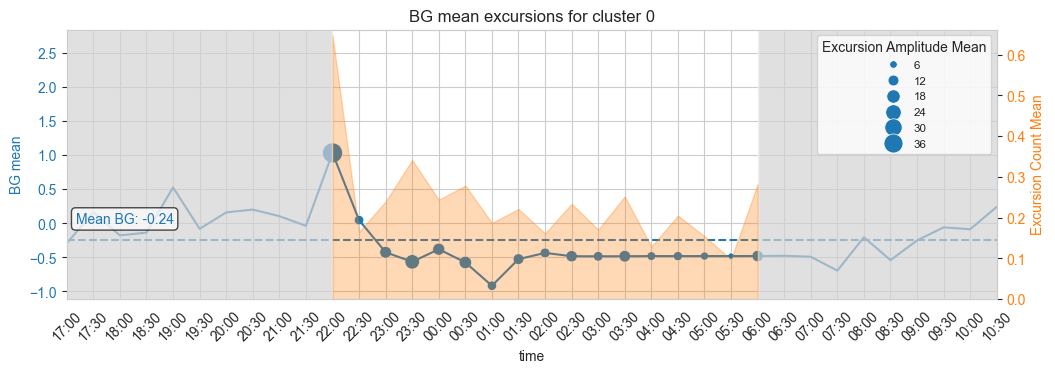

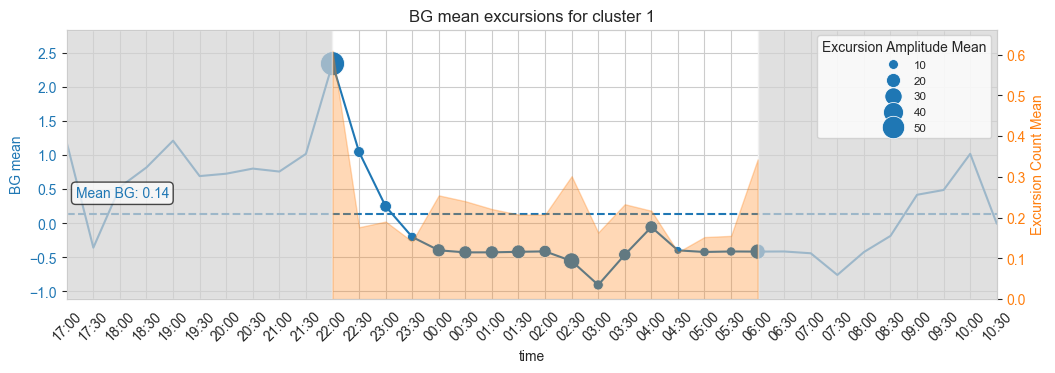

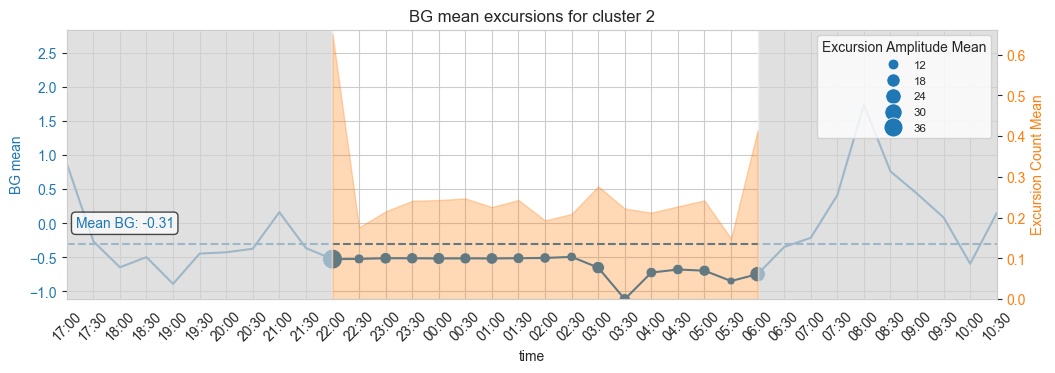

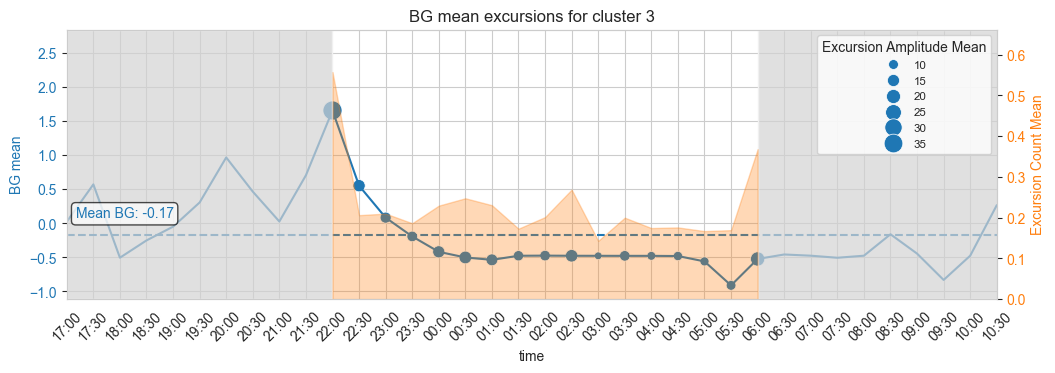

In [12]:
primary_y_lim = (df_long_bg['bg mean'].min(), df_long_bg['bg mean'].max() + 0.5)
secondary_y_lim = (0, df_long_bg['excursion_count_mean'].max() + 0.01)
global_marker_size = (df_long_bg['excursion_mean'].min(), df_long_bg['excursion_mean'].max())
for cluster, cluster_df in df_long_bg.groupby('cluster'):
    mean_bg = cluster_df['bg mean'].mean()
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    sns.lineplot(data=cluster_df, x='time', y='bg mean', ax=ax1, color='tab:blue')
    ax1.set_ylabel('BG mean', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(primary_y_lim)
    sns.scatterplot(data=cluster_df, x='time', y='bg mean', size='excursion_mean', sizes=(20, 300), size_norm=global_marker_size, ax=ax1)
    ax1.legend(title='Excursion Amplitude Mean', loc='upper right', fontsize='small')
    ax1.axhline(mean_bg, color='tab:blue', linestyle='--', label='Mean BG')
    ax1.annotate(f'Mean BG: {mean_bg:.2f}', xy=(cluster_df.index.get_level_values('time').min()+timedelta(minutes=10), mean_bg),
                 xycoords='data', xytext=(0, 10), textcoords='offset points',
                 color='tab:blue', fontsize=10, va='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.7), zorder=10)

    ax2 = ax1.twinx()
    ax2.fill_between(cluster_df.index.get_level_values('time'), cluster_df['excursion_count_mean'], color='tab:orange', alpha=0.3)
    ax2.set_ylabel('Excursion Count Mean', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylim(secondary_y_lim)

    ax2.grid(False)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    for label in ax1.get_xticklabels():
        label.set_rotation(45)
    min_time_dt = cluster_df.index.get_level_values('time').min()
    max_time_dt = cluster_df.index.get_level_values('time').max()
    ax1.set_xlim(min_time_dt, max_time_dt)

    shade_periods = [
        (datetime(1900, 1, 1, 17, 0), datetime(1900, 1, 1, 22, 0)), # 17:00 to 22:00
        (datetime(1900, 1, 2, 6, 0), datetime(1900, 1, 2, 11, 0))   # 06:00 to 11:00 (next day)
    ]
    for start_dt_obj, end_dt_obj in shade_periods:
        ax1.axvspan(start_dt_obj, end_dt_obj, facecolor='lightgray', alpha=0.7, zorder=3)

    plt.title(f'BG mean excursions for cluster {cluster}')
    plt.show()

BG mean excursions for cluster 0


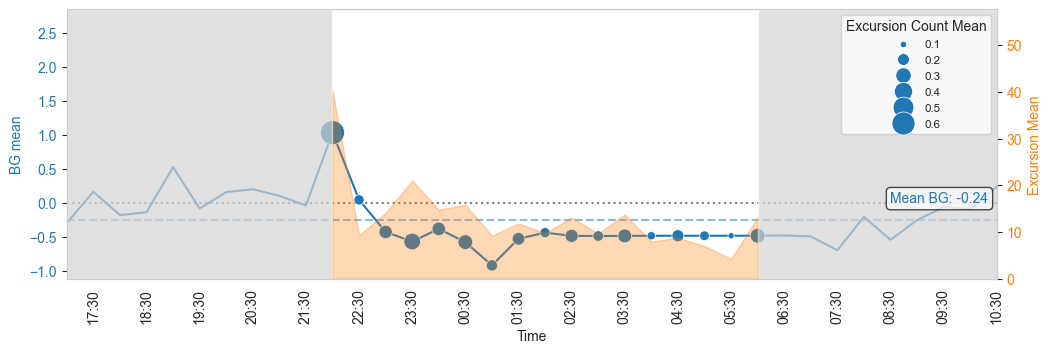

BG mean excursions for cluster 1


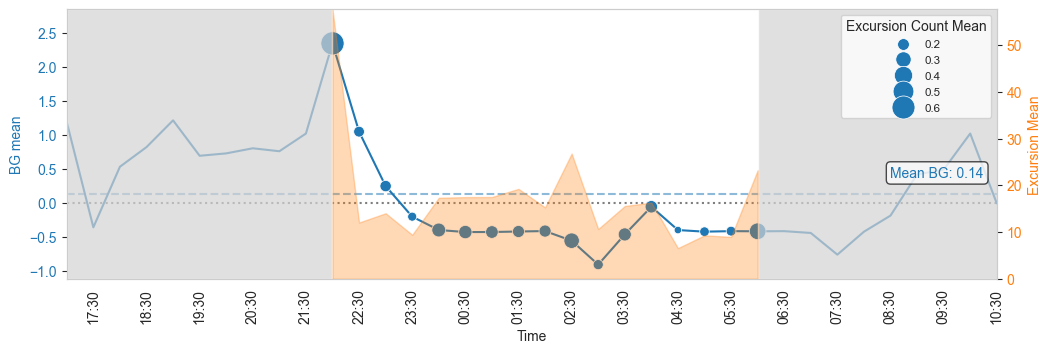

BG mean excursions for cluster 2


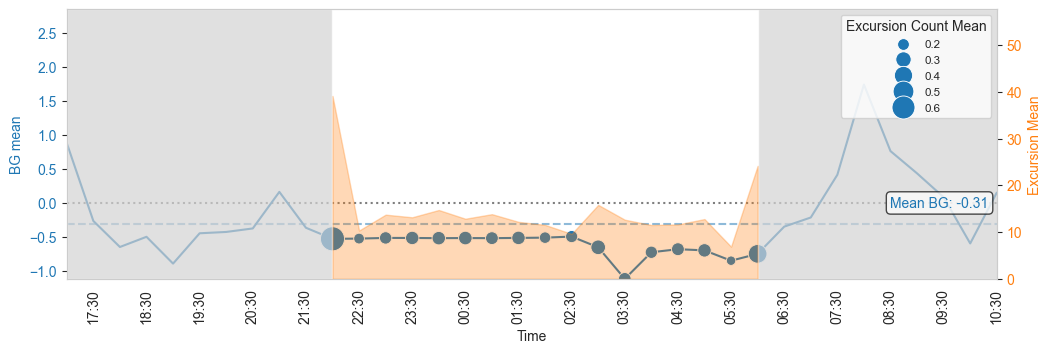

BG mean excursions for cluster 3


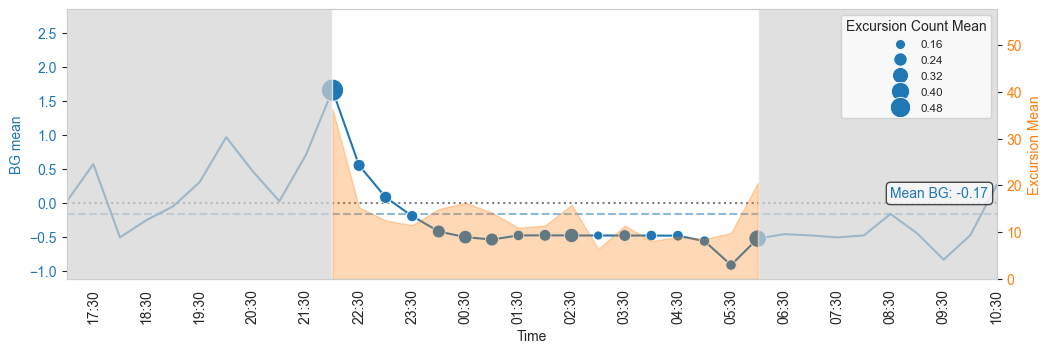

In [13]:
def plot_mage_timelines(df, size_variable, secondary_y_variable):
    primary_y_lim = (df['bg mean'].min(), df['bg mean'].max() + 0.5)
    secondary_y_lim = (0, df[secondary_y_variable].max() + 0.01)
    global_marker_size = (df[size_variable].min(), df[size_variable].max())
    for cluster, cluster_df in df.groupby('cluster'):
        print(f'BG mean excursions for cluster {cluster}')
        mean_bg = cluster_df['bg mean'].mean()
        fig, ax1 = plt.subplots(figsize=(12, 3.5))
        sns.lineplot(data=cluster_df, x='time', y='bg mean', ax=ax1, color='tab:blue', zorder=3)
        ax1.set_ylabel('BG mean', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.set_ylim(primary_y_lim)
        sns.scatterplot(data=cluster_df, x='time', y='bg mean', size=size_variable, sizes=(20, 300), size_norm=global_marker_size, ax=ax1, zorder=3)
        ax1.legend(title=size_variable.replace('_', ' ').title(), loc='upper right', fontsize='small')
        ax1.axhline(mean_bg, color='tab:blue', linestyle='--', label='Mean BG', alpha=0.5)
        ax1.axhline(0, color='tab:grey', linestyle=':', label='Zero Line')
        ax1.annotate(f'Mean BG: {mean_bg:.2f}', xy=(cluster_df.index.get_level_values('time').max()-timedelta(minutes=120), mean_bg),
                     xycoords='data', xytext=(0, 10), textcoords='offset points',
                     color='tab:blue', fontsize=10, va='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.7), zorder=10)

        ax2 = ax1.twinx()
        ax2.fill_between(cluster_df.index.get_level_values('time'), cluster_df[secondary_y_variable], color='tab:orange', alpha=0.3, zorder=1)
        ax2.set_ylabel(secondary_y_variable.replace('_', ' ').title(), color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        ax2.set_ylim(secondary_y_lim)
        ax2.grid(False)

        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        for label in ax1.get_xticklabels():
            label.set_rotation(90)
        min_time_dt = cluster_df.index.get_level_values('time').min()
        max_time_dt = cluster_df.index.get_level_values('time').max()
        ax1.set_xlim(min_time_dt, max_time_dt)
        ax1.set_xlabel('Time')
        ax1.grid(False)

        shade_periods = [
            (datetime(1900, 1, 1, 17, 0), datetime(1900, 1, 1, 22, 0)), # 17:00 to 22:00
            (datetime(1900, 1, 2, 6, 0), datetime(1900, 1, 2, 11, 0))   # 06:00 to 11:00 (next day)
        ]
        for start_dt_obj, end_dt_obj in shade_periods:
            ax1.axvspan(start_dt_obj, end_dt_obj, facecolor='lightgray', alpha=0.7, zorder=3)

        plt.savefig(FIGURES_DIR / f'bg_mean_excursions_cluster_{cluster}.png', bbox_inches='tight')
        plt.show()

plot_mage_timelines(df_long_bg, 'excursion_count_mean', 'excursion_mean')

In [14]:
df_long_bg.groupby('cluster').agg(
    bg_mean=('bg mean', 'mean'),
    excursion_count_mean=('excursion_count_mean', 'mean'),
    excursion_sum=('excursion_sum', 'sum'),
    excursion_mean=('excursion_mean', 'mean')
)

,bg_mean,excursion_count_mean,excursion_sum,excursion_mean
cluster,,,,
0,-0.242093,0.235943,27462.053024,13.171486
1,0.135002,0.231214,31187.531746,17.490545
2,-0.305709,0.258332,64552.843109,14.499791
3,-0.166064,0.229961,98403.833920,13.685402
